In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os
import random
import sys
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from tqdm import tqdm
from sklearn.metrics import log_loss

import pandas as pd

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(42)

# Data 

In [3]:
train = pd.read_csv('../data/01_raw/train_features.csv')
train_targets_scored = pd.read_csv('../data/01_raw/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../data/01_raw/train_targets_nonscored.csv')
test_features = pd.read_csv('../data/01_raw/test_features.csv')
submission = pd.read_csv('../data/01_raw/sample_submission.csv')


#
cp_time=24
cp_dose='D1'

remove_vehicle = True

if remove_vehicle:

    mask = train.loc[(train['cp_type']=='trt_cp')].index
                     #(train['cp_time']==cp_time) &
                     #(train['cp_dose']==cp_dose)].index

    train_features = train.loc[mask].reset_index(drop=True)
    train_targets_scored = train_targets_scored.loc[mask].reset_index(drop=True)
    train_targets_nonscored = train_targets_nonscored.loc[mask].reset_index(drop=True)


    # test_features = test_features.loc[(test_features['cp_type']=='trt_cp') &
    #                  (test_features['cp_time']==cp_time) &
    #                  (test_features['cp_dose']==cp_dose)].reset_index(drop=True)

else:
    train_features = train

In [4]:
c_cols = ["c-"+str(c) for c in range(0,99+1)]

g_cols = ["g-"+str(c) for c in range(0,771+1)]

In [5]:


from sklearn.cluster import AgglomerativeClustering


c_cols = ["c-"+str(c) for c in range(0,99+1)]

g_cols = ["g-"+str(c) for c in range(0,771+1)]





#full_df = pd.concat([train_features[c_cols+g_cols],test_features[c_cols+g_cols]]).reset_index(drop=True)

full_df_c = pd.concat([train_features[c_cols],test_features[c_cols]]).reset_index(drop=True)
full_df_g = pd.concat([train_features[g_cols],test_features[g_cols]]).reset_index(drop=True)



from sklearn.preprocessing import StandardScaler

# Standardizing the features
full_df = StandardScaler().fit_transform(full_df)
# full_df_c = StandardScaler().fit_transform(full_df_c)
# full_df_g = StandardScaler().fit_transform(full_df_g)

In [6]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [7]:


clus_c = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage="ward").fit(full_df_c)

clus_g = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage="ward").fit(full_df_g)

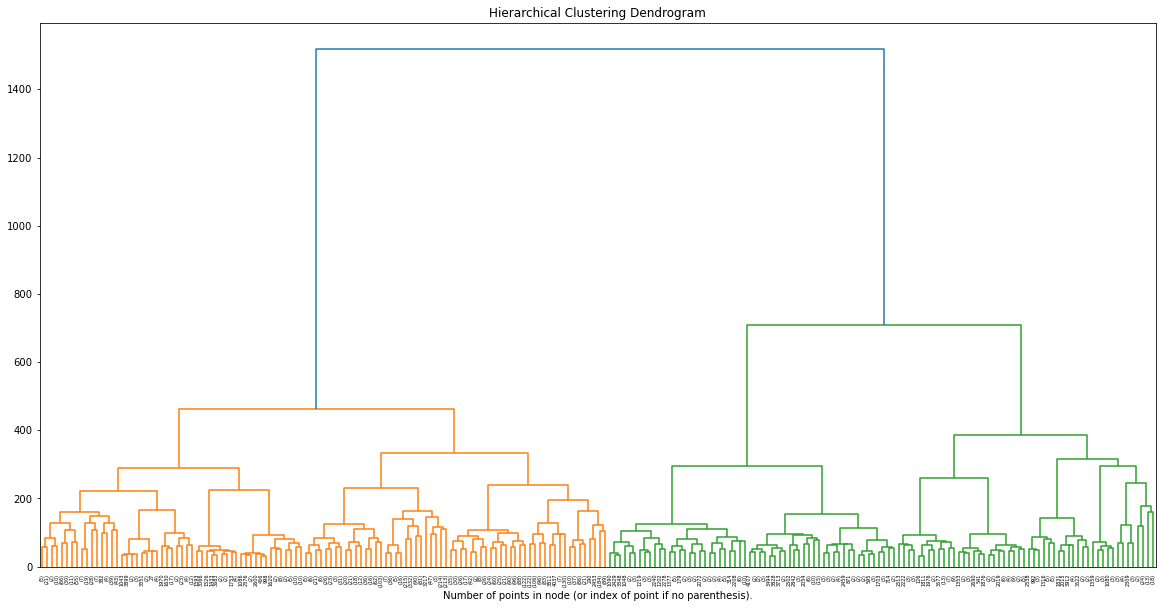

In [8]:

# plot the top three levels of the dendrogram

fig = plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram')

plot_dendrogram(clus_g, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [9]:
c_thresh = 100
g_thresh = 200

# thresh = 1500


# clus = AgglomerativeClustering(distance_threshold=thresh, 
#                                n_clusters=None, 
#                                affinity='euclidean', 
#                                linkage="ward").fit(full_df)

clus_c = AgglomerativeClustering(distance_threshold=c_thresh,
                               n_clusters=None,
                               affinity='euclidean',
                               linkage="ward").fit(full_df_c)


clus_g = AgglomerativeClustering(distance_threshold=g_thresh,
                               n_clusters=None,
                               affinity='euclidean',
                               linkage="ward").fit(full_df_g)

In [10]:
# train_features["clus"] = clus.labels_[train_features.index]

# test_features["clus"] = clus.labels_[test_features.index+train_features.shape[0]]



train_features["clus_c"] = clus_c.labels_[train_features.index]
train_features["clus_g"] = clus_g.labels_[train_features.index]


test_features["clus_c"] = clus_c.labels_[test_features.index+train_features.shape[0]]
test_features["clus_g"] = clus_g.labels_[test_features.index+train_features.shape[0]]

In [11]:
# print(f"NBre of clusters : {clus.n_clusters_}")

print(f"NBre of c clusters : {clus_c.n_clusters_}")
print(f"NBre of g clusters : {clus_g.n_clusters_}")

NBre of c clusters : 7
NBre of g clusters : 16


In [5]:
# Rankgauss preprocessing
from sklearn.preprocessing import QuantileTransformer

#RankGauss

for col in (c_cols + g_cols):

    transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [6]:
def add_feat(df):
    #df['c_med'] = df[c_cols].median(axis = 1)
    #df['g_med'] = df[g_cols].median(axis = 1)
    # df['g_sum'] = df[g_cols].sum(axis = 1)
    # df['g_mean'] = df[g_cols].mean(axis = 1)
    df['g_std'] = df[g_cols].std(axis = 1)
    # df['g_kurt'] = df[g_cols].kurtosis(axis = 1)
    # df['g_skew'] = df[g_cols].skew(axis = 1)
    # df['c_sum'] = df[c_cols].sum(axis = 1)
    # df['c_mean'] = df[c_cols].mean(axis = 1)
    # df['c_std'] = df[c_cols].std(axis = 1)
    # df['c_kurt'] = df[c_cols].kurtosis(axis = 1)
    # df['c_skew'] = df[c_cols].skew(axis = 1)
    # df['gc_sum'] = df[g_cols + c_cols].sum(axis = 1)
    # df['gc_mean'] = df[g_cols + c_cols].mean(axis = 1)
    # df['gc_std'] = df[g_cols + c_cols].std(axis = 1)
    # df['gc_kurt'] = df[g_cols + c_cols].kurtosis(axis = 1)
    # df['gc_skew'] = df[g_cols + c_cols].skew(axis = 1)

In [7]:
# add_feat(train_features)
# add_feat(test_features)

In [8]:
# ratio for each label

def get_ratio_labels(df):
    columns = list(df.columns)
    columns.pop(0)
    ratios = []
    toremove = []
    for c in columns:
        counts = df[c].value_counts()
        if len(counts) != 1:
            ratios.append(counts[0]/counts[1])
        else:
            toremove.append(c)
    print(f"remove {len(toremove)} columns")
    
    for t in toremove:
        columns.remove(t)
    return columns, np.array(ratios).astype(np.int32)

columns, ratios = get_ratio_labels(train_targets_scored)
columns_nonscored, ratios_nonscored = get_ratio_labels(train_targets_nonscored)

remove 0 columns
remove 71 columns


# Dataloader

In [9]:
def transform_data(train, test, col, normalize=True, removed_vehicle=False):
    """
        the first 3 columns represents categories, the others numericals features
    """
    mapping = {"cp_type":{"trt_cp": 0, "ctl_vehicle":1},
               "cp_time":{48:0, 72:1, 24:2},
               "cp_dose":{"D1":0, "D2":1}}
    
    if removed_vehicle:
        categories_tr = np.stack([ train[c].apply(lambda x: mapping[c][x]).values for c in col[1:3]], axis=1)
        categories_test = np.stack([ test[c].apply(lambda x: mapping[c][x]).values for c in col[1:3]], axis=1)
    else:
        categories_tr = np.stack([ train[c].apply(lambda x: mapping[c][x]).values for c in col[:3]], axis=1)
        categories_test = np.stack([ test[c].apply(lambda x: mapping[c][x]).values for c in col[:3]], axis=1)
    
    max_ = 10.
    min_ = -10.
   
    if removed_vehicle:
        numerical_tr = train[col[3:]].values
        numerical_test = test[col[3:]].values
    else:
        numerical_tr = train[col[3:]].values
        numerical_test = test[col[3:]].values
        
    if normalize:
        numerical_tr = (numerical_tr-min_)/(max_ - min_)
        numerical_test = (numerical_test-min_)/(max_ - min_)
    return categories_tr, categories_test, numerical_tr, numerical_test



col_features = list(train_features.columns)[1:]
cat_tr, cat_test, numerical_tr, numerical_test = transform_data(train_features, test_features, col_features, normalize=False, removed_vehicle=remove_vehicle)
targets_tr = train_targets_scored[columns].values.astype(np.float32)
targets2_tr = train_targets_nonscored[columns_nonscored].values.astype(np.float32)

# Utils

In [10]:
def evals(model, X, y, verbose=True):
    with torch.no_grad():
        y_preds = model.predict(X)
        y_preds = torch.clamp(y_preds, 0.0,1.0).detach().numpy()
    score = log_loss_multi(y, y_preds)
    #print("Logloss = ", score)
    return y_preds, score


def inference_fn(model, X ,verbose=True):
    with torch.no_grad():
        y_preds = model.predict( X )
        y_preds = torch.sigmoid(torch.as_tensor(y_preds)).numpy()
    return y_preds

In [11]:
def log_loss_score(actual, predicted,  eps=1e-15):

        """
        :param predicted:   The predicted probabilities as floats between 0-1
        :param actual:      The binary labels. Either 0 or 1.
        :param eps:         Log(0) is equal to infinity, so we need to offset our predicted values slightly by eps from 0 or 1
        :return:            The logarithmic loss between between the predicted probability assigned to the possible outcomes for item i, and the actual outcome.
        """

        
        p1 = actual * np.log(predicted+eps)
        p0 = (1-actual) * np.log(1-predicted+eps)
        loss = p0 + p1

        return -loss.mean()

In [12]:
def log_loss_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        results[i] = log_loss_score(y_true[:,i], y_pred[:,i])
    return results.mean()

In [13]:
def check_targets(targets):
    ### check if targets are all binary in training set
    
    for i in range(targets.shape[1]):
        if len(np.unique(targets[:,i])) != 2:
            return False
    return True

In [14]:
def auc_multi(y_true, y_pred):
    M = y_true.shape[1]
    results = np.zeros(M)
    for i in range(M):
        try:
            results[i] = roc_auc_score(y_true[:,i], y_pred[:,i])
        except:
            pass
    return results.mean()

# Model

In [33]:
import pytorch_tabnet


In [15]:
# TABNET

import torch
import numpy as np
from scipy.sparse import csc_matrix
import time
from abc import abstractmethod
from pytorch_tabnet import tab_network
from pytorch_tabnet.multiclass_utils import unique_labels
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from torch.nn.utils import clip_grad_norm_
from pytorch_tabnet.utils import (PredictDataset,
                                  create_dataloaders,
                                  create_explain_matrix)
from sklearn.base import BaseEstimator
from torch.utils.data import DataLoader
from copy import deepcopy
import io
import json
from pathlib import Path
import shutil
import zipfile

In [16]:


class TabModel(BaseEstimator):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1,
                 n_independent=2, n_shared=2, epsilon=1e-15,  momentum=0.02,
                 lambda_sparse=1e-3, seed=0,
                 clip_value=1, verbose=1,
                 optimizer_fn=torch.optim.Adam,
                 optimizer_params=dict(lr=2e-2),
                 scheduler_params=None, scheduler_fn=None,
                 mask_type="sparsemax",
                 input_dim=None, output_dim=None,
                 device_name='auto'):
        """ Class for TabNet model
        Parameters
        ----------
            device_name: str
                'cuda' if running on GPU, 'cpu' if not, 'auto' to autodetect
        """

        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.cat_idxs = cat_idxs
        self.cat_dims = cat_dims
        self.cat_emb_dim = cat_emb_dim
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.epsilon = epsilon
        self.momentum = momentum
        self.lambda_sparse = lambda_sparse
        self.clip_value = clip_value
        self.verbose = verbose
        self.optimizer_fn = optimizer_fn
        self.optimizer_params = optimizer_params
        self.device_name = device_name
        self.scheduler_params = scheduler_params
        self.scheduler_fn = scheduler_fn
        self.mask_type = mask_type
        self.input_dim = input_dim
        self.output_dim = output_dim

        #self.batch_size = 1024
        self.batch_size = 2048

        self.seed = seed
        torch.manual_seed(self.seed)
        # Defining device
        if device_name == 'auto':
            if torch.cuda.is_available():
                device_name = 'cuda'
            else:
                device_name = 'cpu'
        self.device = torch.device(device_name)
        print(f"Device used : {self.device}")

    @abstractmethod
    def construct_loaders(self, X_train, y_train, X_valid, y_valid,
                          weights, batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        raise NotImplementedError('users must define construct_loaders to use this base class')

    def init_network(
                     self,
                     input_dim,
                     output_dim,
                     n_d,
                     n_a,
                     n_steps,
                     gamma,
                     cat_idxs,
                     cat_dims,
                     cat_emb_dim,
                     n_independent,
                     n_shared,
                     epsilon,
                     virtual_batch_size,
                     momentum,
                     device_name,
                     mask_type,
                     ):
        self.network = tab_network.TabNet(
            input_dim,
            output_dim,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=cat_emb_dim,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            device_name=device_name,
            mask_type=mask_type).to(self.device)

        self.reducing_matrix = create_explain_matrix(
            self.network.input_dim,
            self.network.cat_emb_dim,
            self.network.cat_idxs,
            self.network.post_embed_dim)

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, loss_fn=None,
            weights=0, max_epochs=100, patience=10, batch_size=1024,
            virtual_batch_size=128, num_workers=0, drop_last=False):
        """Train a neural network stored in self.network
        Using train_dataloader for training data and
        valid_dataloader for validation.
        Parameters
        ----------
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            X_train: np.ndarray
                Train set
            y_train : np.array
                Train targets
            weights : bool or dictionnary
                0 for no balancing
                1 for automated balancing
                dict for custom weights per class
            max_epochs : int
                Maximum number of epochs during training
            patience : int
                Number of consecutive non improving epoch before early stopping
            batch_size : int
                Training batch size
            virtual_batch_size : int
                Batch size for Ghost Batch Normalization (virtual_batch_size < batch_size)
            num_workers : int
                Number of workers used in torch.utils.data.DataLoader
            drop_last : bool
                Whether to drop last batch during training
        """
        # update model name

        self.update_fit_params(X_train, y_train, X_valid, y_valid, loss_fn,
                               weights, max_epochs, patience, batch_size,
                               virtual_batch_size, num_workers, drop_last)

        train_dataloader, valid_dataloader = self.construct_loaders(X_train,
                                                                    y_train,
                                                                    X_valid,
                                                                    y_valid,
                                                                    self.updated_weights,
                                                                    self.batch_size,
                                                                    self.num_workers,
                                                                    self.drop_last)

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=self.virtual_batch_size,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )

        self.optimizer = self.optimizer_fn(self.network.parameters(),
                                           **self.optimizer_params)

        if self.scheduler_fn:
            self.scheduler = self.scheduler_fn(self.optimizer, **self.scheduler_params)
        else:
            self.scheduler = None

        self.losses_train = []
        self.losses_valid = []
        self.learning_rates = []
        self.metrics_train = []
        self.metrics_valid = []

        if self.verbose > 0:
            print("Will train until validation stopping metric",
                  f"hasn't improved in {self.patience} rounds.")
            msg_epoch = f'| EPOCH |  train  |   valid  | total time (s)'
            print('---------------------------------------')
            print(msg_epoch)

        total_time = 0
        while (self.epoch < self.max_epochs and
               self.patience_counter < self.patience):
            starting_time = time.time()
            # updates learning rate history
            self.learning_rates.append(self.optimizer.param_groups[-1]["lr"])

            fit_metrics = self.fit_epoch(train_dataloader, valid_dataloader)

            # leaving it here, may be used for callbacks later
            self.losses_train.append(fit_metrics['train']['loss_avg'])
            self.losses_valid.append(fit_metrics['valid']['total_loss'])
            self.metrics_train.append(fit_metrics['train']['stopping_loss'])
            self.metrics_valid.append(fit_metrics['valid']['stopping_loss'])

            stopping_loss = fit_metrics['valid']['stopping_loss']
            if stopping_loss < self.best_cost:
                self.best_cost = stopping_loss
                self.patience_counter = 0
                # Saving model
                self.best_network = deepcopy(self.network)
                has_improved = True
            else:
                self.patience_counter += 1
                has_improved=False
            self.epoch += 1
            total_time += time.time() - starting_time
            if self.verbose > 0:
                if self.epoch % self.verbose == 0:
                    separator = "|"
                    msg_epoch = f"| {self.epoch:<5} | "
                    msg_epoch += f" {fit_metrics['train']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {fit_metrics['valid']['stopping_loss']:.5f}"
                    msg_epoch += f' {separator:<2} '
                    msg_epoch += f" {np.round(total_time, 1):<10}"
                    msg_epoch += f" {has_improved}"
                    print(msg_epoch)

        if self.verbose > 0:
            if self.patience_counter == self.patience:
                print(f"Early stopping occured at epoch {self.epoch}")
            print(f"Training done in {total_time:.3f} seconds.")
            print('---------------------------------------')

        self.history = {"train": {"loss": self.losses_train,
                                  "metric": self.metrics_train,
                                  "lr": self.learning_rates},
                        "valid": {"loss": self.losses_valid,
                                  "metric": self.metrics_valid}}
        # load best models post training
        self.load_best_model()

        # compute feature importance once the best model is defined
        self._compute_feature_importances(train_dataloader)

    def save_model(self, path):
        """
        Saving model with two distinct files.
        """
        saved_params = {}
        for key, val in self.get_params().items():
            if isinstance(val, type):
                # Don't save torch specific params
                continue
            else:
                saved_params[key] = val

        # Create folder
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save models params
        with open(Path(path).joinpath("model_params.json"), "w", encoding="utf8") as f:
            json.dump(saved_params, f)

        # Save state_dict
        torch.save(self.network.state_dict(), Path(path).joinpath("network.pt"))
        shutil.make_archive(path, 'zip', path)
        shutil.rmtree(path)
        print(f"Successfully saved model at {path}.zip")
        return f"{path}.zip"

    def load_model(self, filepath):

        try:
            try:
                with zipfile.ZipFile(filepath) as z:
                    with z.open("model_params.json") as f:
                        loaded_params = json.load(f)
                    with z.open("network.pt") as f:
                        try:
                            saved_state_dict = torch.load(f)
                        except io.UnsupportedOperation:
                            # In Python <3.7, the returned file object is not seekable (which at least
                            # some versions of PyTorch require) - so we'll try buffering it in to a
                            # BytesIO instead:
                            saved_state_dict = torch.load(io.BytesIO(f.read()))
                            
            except:
                with open(os.path.join(filepath, "model_params.json")) as f:
                        loaded_params = json.load(f)

                saved_state_dict = torch.load(os.path.join(filepath, "network.pt"), map_location="cpu")
 
        except KeyError:
            raise KeyError("Your zip file is missing at least one component")

        #print(loaded_params)
        if torch.cuda.is_available():
            device_name = 'cuda'
        else:
            device_name = 'cpu'
        loaded_params["device_name"] = device_name
        self.__init__(**loaded_params)
        
        

        self.init_network(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            cat_idxs=self.cat_idxs,
            cat_dims=self.cat_dims,
            cat_emb_dim=self.cat_emb_dim,
            n_independent=self.n_independent,
            n_shared=self.n_shared,
            epsilon=self.epsilon,
            virtual_batch_size=1024,
            momentum=self.momentum,
            device_name=self.device_name,
            mask_type=self.mask_type
        )
        self.network.load_state_dict(saved_state_dict)
        self.network.eval()
        return

    def fit_epoch(self, train_dataloader, valid_dataloader):
        """
        Evaluates and updates network for one epoch.
        Parameters
        ----------
            train_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
            valid_dataloader: a :class: `torch.utils.data.Dataloader`
                DataLoader with valid set
        """
        train_metrics = self.train_epoch(train_dataloader)
        valid_metrics = self.predict_epoch(valid_dataloader)

        fit_metrics = {'train': train_metrics,
                       'valid': valid_metrics}

        return fit_metrics

    @abstractmethod
    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """
        raise NotImplementedError('users must define train_epoch to use this base class')

    @abstractmethod
    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        raise NotImplementedError('users must define train_batch to use this base class')

    @abstractmethod
    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        raise NotImplementedError('users must define predict_epoch to use this base class')

    @abstractmethod
    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        raise NotImplementedError('users must define predict_batch to use this base class')

    def load_best_model(self):
        if self.best_network is not None:
            self.network = self.best_network

    @abstractmethod
    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem or the last class
        """
        raise NotImplementedError('users must define predict to use this base class')

    def explain(self, X):
        """
        Return local explanation
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            M_explain: matrix
                Importance per sample, per columns.
            masks: matrix
                Sparse matrix showing attention masks used by network.
        """
        self.network.eval()

        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            M_explain, masks = self.network.forward_masks(data)
            for key, value in masks.items():
                masks[key] = csc_matrix.dot(value.cpu().detach().numpy(),
                                            self.reducing_matrix)

            if batch_nb == 0:
                res_explain = csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                             self.reducing_matrix)
                res_masks = masks
            else:
                res_explain = np.vstack([res_explain,
                                         csc_matrix.dot(M_explain.cpu().detach().numpy(),
                                                        self.reducing_matrix)])
                for key, value in masks.items():
                    res_masks[key] = np.vstack([res_masks[key], value])
        return res_explain, res_masks

    def _compute_feature_importances(self, loader):
        self.network.eval()
        feature_importances_ = np.zeros((self.network.post_embed_dim))
        for data, targets in loader:
            data = data.to(self.device).float()
            M_explain, masks = self.network.forward_masks(data)
            feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

        feature_importances_ = csc_matrix.dot(feature_importances_,
                                              self.reducing_matrix)
        self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)
        


class TabNetRegressor(TabModel):

    def construct_loaders(self, X_train, y_train, X_valid, y_valid, weights,
                          batch_size, num_workers, drop_last):
        """
        Returns
        -------
        train_dataloader, valid_dataloader : torch.DataLoader, torch.DataLoader
            Training and validation dataloaders
        -------
        """
        if isinstance(weights, int):
            if weights == 1:
                raise ValueError("Please provide a list of weights for regression.")
        if isinstance(weights, dict):
            raise ValueError("Please provide a list of weights for regression.")

        train_dataloader, valid_dataloader = create_dataloaders(X_train,
                                                                y_train,
                                                                X_valid,
                                                                y_valid,
                                                                weights,
                                                                batch_size,
                                                                num_workers,
                                                                drop_last)
        return train_dataloader, valid_dataloader

    def update_fit_params(self, X_train, y_train, X_valid, y_valid, loss_fn,
                          weights, max_epochs, patience,
                          batch_size, virtual_batch_size, num_workers, drop_last):

        if loss_fn is None:
            self.loss_fn = torch.nn.functional.mse_loss
        else:
            self.loss_fn = loss_fn

        assert X_train.shape[1] == X_valid.shape[1], "Dimension mismatch X_train X_valid"
        self.input_dim = X_train.shape[1]

        if len(y_train.shape) == 1:
            raise ValueError("""Please apply reshape(-1, 1) to your targets
                                if doing single regression.""")
        assert y_train.shape[1] == y_valid.shape[1], "Dimension mismatch y_train y_valid"
        self.output_dim = y_train.shape[1]

        self.updated_weights = weights

        self.max_epochs = max_epochs
        self.patience = patience
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        # Initialize counters and histories.
        self.patience_counter = 0
        self.epoch = 0
        self.best_cost = np.inf
        self.num_workers = num_workers
        self.drop_last = drop_last

    def train_epoch(self, train_loader):
        """
        Trains one epoch of the network in self.network
        Parameters
        ----------
            train_loader: a :class: `torch.utils.data.Dataloader`
                DataLoader with train set
        """

        self.network.train()
        y_preds = []
        ys = []
        total_loss = 0

        for data, targets in train_loader:
            batch_outs = self.train_batch(data, targets)
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())
            total_loss += batch_outs["loss"]

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        #stopping_loss = mean_squared_error(y_true=ys, y_pred=y_preds)
        stopping_loss =log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  )
        total_loss = total_loss / len(train_loader)
        epoch_metrics = {'loss_avg': total_loss,
                         'stopping_loss': total_loss,
                         }

        if self.scheduler is not None:
            self.scheduler.step()
        return epoch_metrics

    def train_batch(self, data, targets):
        """
        Trains one batch of data
        Parameters
        ----------
            data: a :tensor: `torch.tensor`
                Input data
            target: a :tensor: `torch.tensor`
                Target data
        """
        self.network.train()
        data = data.to(self.device).float()

        targets = targets.to(self.device).float()
        self.optimizer.zero_grad()

        output, M_loss = self.network(data)

        loss = self.loss_fn(output, targets)
        
        loss -= self.lambda_sparse*M_loss

        loss.backward()
        if self.clip_value:
            clip_grad_norm_(self.network.parameters(), self.clip_value)
        self.optimizer.step()

        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict_epoch(self, loader):
        """
        Validates one epoch of the network in self.network
        Parameters
        ----------
            loader: a :class: `torch.utils.data.Dataloader`
                    DataLoader with validation set
        """
        y_preds = []
        ys = []
        self.network.eval()
        total_loss = 0

        for data, targets in loader:
            batch_outs = self.predict_batch(data, targets)
            total_loss += batch_outs["loss"]
            y_preds.append(batch_outs["y_preds"].cpu().detach().numpy())
            ys.append(batch_outs["y"].cpu().detach().numpy())

        y_preds = np.vstack(y_preds)
        ys = np.vstack(ys)

        stopping_loss =log_loss_multi(ys, torch.sigmoid(torch.as_tensor(y_preds)).numpy()  ) #mean_squared_error(y_true=ys, y_pred=y_preds)

        total_loss = total_loss / len(loader)
        epoch_metrics = {'total_loss': total_loss,
                         'stopping_loss': stopping_loss}

        return epoch_metrics

    def predict_batch(self, data, targets):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            batch_outs: dict
        """
        self.network.eval()
        data = data.to(self.device).float()
        targets = targets.to(self.device).float()

        output, M_loss = self.network(data)
       
        loss = self.loss_fn(output, targets)
        #print(self.loss_fn, loss)
        loss -= self.lambda_sparse*M_loss
        #print(loss)
        loss_value = loss.item()
        batch_outs = {'loss': loss_value,
                      'y_preds': output,
                      'y': targets}
        return batch_outs

    def predict(self, X):
        """
        Make predictions on a batch (valid)
        Parameters
        ----------
            data: a :tensor: `torch.Tensor`
                Input data
            target: a :tensor: `torch.Tensor`
                Target data
        Returns
        -------
            predictions: np.array
                Predictions of the regression problem
        """
        self.network.eval()
        dataloader = DataLoader(PredictDataset(X),
                                batch_size=self.batch_size, shuffle=False)

        results = []
        for batch_nb, data in enumerate(dataloader):
            data = data.to(self.device).float()

            output, M_loss = self.network(data)
            predictions = output.cpu().detach().numpy()
            results.append(predictions)
        res = np.vstack(results)
        return res

In [17]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

In [18]:
class Config(object):
    def __init__(self):
        self.num_class = targets_tr.shape[1]
        self.verbose=False
        #
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.SPLITS = 10
        self.EPOCHS = 300
        self.num_ensembling = 1
        self.seed = 0
        # Parameters model
        self.cat_emb_dim=[1] * cat_tr.shape[1] #to choose
        self.cats_idx = list(range(cat_tr.shape[1]))
        self.cat_dims = [len(np.unique(cat_tr[:, i])) for i in range(cat_tr.shape[1])]
        self.num_numericals= numerical_tr.shape[1]
        # save
        self.save_name = "../data/tabnet-weights-public/tabnet-raw-public-step1/tabnet_raw_step1"
        
        self.strategy = "KFOLD" # 
cfg = Config()

In [19]:
X_test = np.concatenate([cat_test, numerical_test ], axis=1)

In [24]:
if cfg.strategy == "KFOLD":
    oof_preds_all = []
    oof_targets_all = []
    scores_all =  []
    scores_auc_all= []
    for seed in range(cfg.num_ensembling):
        print("## SEED : ", seed)
        mskf = MultilabelStratifiedKFold(n_splits=cfg.SPLITS, random_state=cfg.seed+seed, shuffle=True)
        oof_preds = []
        oof_targets = []
        scores = []
        scores_auc = []
        for j, (train_idx, val_idx) in enumerate(mskf.split(np.zeros(len(cat_tr)), targets_tr)):
            print("FOLDS : ", j)

            ## model
            X_train, y_train = torch.as_tensor(np.concatenate([cat_tr[train_idx], numerical_tr[train_idx] ], axis=1)), torch.as_tensor(targets_tr[train_idx])
            X_val, y_val = torch.as_tensor(np.concatenate([cat_tr[val_idx], numerical_tr[val_idx] ], axis=1)), torch.as_tensor(targets_tr[val_idx])
            model = TabNetRegressor(n_d=24, 
                                    n_a=24, 
                                    n_steps=1, 
                                    gamma=1.3, 
                                    lambda_sparse=0, 
                                    cat_dims=cfg.cat_dims, 
                                    cat_emb_dim=cfg.cat_emb_dim, 
                                    cat_idxs=cfg.cats_idx, 
                                    optimizer_fn=torch.optim.Adam,
                                    optimizer_params=dict(lr=2e-2, weight_decay=1e-5), 
                                    mask_type='entmax', 
                                    device_name=cfg.device, 
                                    scheduler_params=dict(milestones=[ 100,150], gamma=0.9), 
                                    scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)
            #'sparsemax'
            
            model.fit(X_train=X_train, 
                      y_train=y_train, 
                      X_valid=X_val, 
                      y_valid=y_val,
                      max_epochs=cfg.EPOCHS,
                      patience=50, 
                      batch_size=1024, 
                      virtual_batch_size=128,
                      num_workers=0, 
                      drop_last=False, 
                      loss_fn=torch.nn.functional.binary_cross_entropy_with_logits)

            model.load_best_model()
            preds = model.predict(X_val)
            preds = torch.sigmoid(torch.as_tensor(preds)).detach().cpu().numpy()
            score = log_loss_multi(y_val, preds)
            name = cfg.save_name + f"_fold{j}_{seed}"
            model.save_model(name)
            ## save oof to compute the CV later
            oof_preds.append(preds)
            oof_targets.append(y_val)
            scores.append(score)
            scores_auc.append(auc_multi(y_val,preds))
            print(f"validation fold {j} : {score}")
        oof_preds_all.append(np.concatenate(oof_preds))
        oof_targets_all.append(np.concatenate(oof_targets))
        scores_all.append(np.array(scores))
        scores_auc_all.append(np.array(scores_auc))

    False
| 57    |  0.01601 |   0.01691 |   102.8      False
| 58    |  0.01597 |   0.01687 |   104.5      False
| 59    |  0.01606 |   0.01713 |   106.3      False
| 60    |  0.01607 |   0.01709 |   108.1      False
| 61    |  0.01586 |   0.01698 |   109.9      False
| 62    |  0.01582 |   0.01714 |   111.7      False
| 63    |  0.01616 |   0.01702 |   113.5      False
| 64    |  0.01604 |   0.01665 |   115.3      True
| 65    |  0.01602 |   0.01698 |   117.1      False
| 66    |  0.01591 |   0.01687 |   118.9      False
| 67    |  0.01593 |   0.01689 |   120.7      False
| 68    |  0.01595 |   0.01713 |   122.5      False
| 69    |  0.01611 |   0.01688 |   124.4      False
| 70    |  0.01597 |   0.01688 |   126.2      False
| 71    |  0.01594 |   0.01710 |   128.0      False
| 72    |  0.01600 |   0.01695 |   129.7      False
| 73    |  0.01593 |   0.01677 |   131.5      False
| 74    |  0.01592 |   0.01761 |   133.3      False
| 75    |  0.01601 |   0.01694 |   135.1      False
| 7

In [25]:
if cfg.strategy == "KFOLD":

    for i in range(cfg.num_ensembling): 
        print("CV score fold : ", log_loss_multi(oof_targets_all[i], oof_preds_all[i]))
        print("auc mean : ", sum(scores_auc_all[i])/len(scores_auc_all[i]))

CV score fold :  0.01659740757358767
auc mean :  0.7252668041447897


In [26]:
#BASELINE
#CV score fold :  0.016605770493997713
#auc mean :  0.7277670023750323

#gaussrank
# CV score fold :  0.016583189296477376
# auc mean :  0.7299140811004048

# clus c, g + gaussrank
#CV score fold :  0.016579642347387916
#auc mean :  0.7288056877236182


scores_all

[array([0.01657629, 0.01659854, 0.0166983 , 0.01659998, 0.01668821,
        0.01640187, 0.01647975, 0.01665361, 0.01660983, 0.01666755])]

In [27]:
scores_auc_all

[array([0.730185  , 0.72868331, 0.73948095, 0.70576325, 0.72938372,
        0.73485281, 0.72650537, 0.72980959, 0.7112753 , 0.71672874])]

In [31]:
print(model)

TabNetRegressor(cat_dims=[3, 2], cat_emb_dim=[1, 1], cat_idxs=[0, 1],
                device_name='cuda', input_dim=875, lambda_sparse=0,
                mask_type='entmax', n_a=24, n_d=24, n_steps=1,
                optimizer_params={'lr': 0.02, 'weight_decay': 1e-05},
                output_dim=206,
                scheduler_fn=<class 'torch.optim.lr_scheduler.MultiStepLR'>,
                scheduler_params={'gamma': 0.9, 'milestones': [100, 150]})


In [28]:
test = pd.DataFrame([[c[0],c[1]] for c in zip(col_features[1:],model.feature_importances_)],columns=["feat","importance"]).sort_values("importance",ascending=False)

In [31]:
test[test["feat"]=="g-1"]

,feat,importance
3,g-1,0.00007


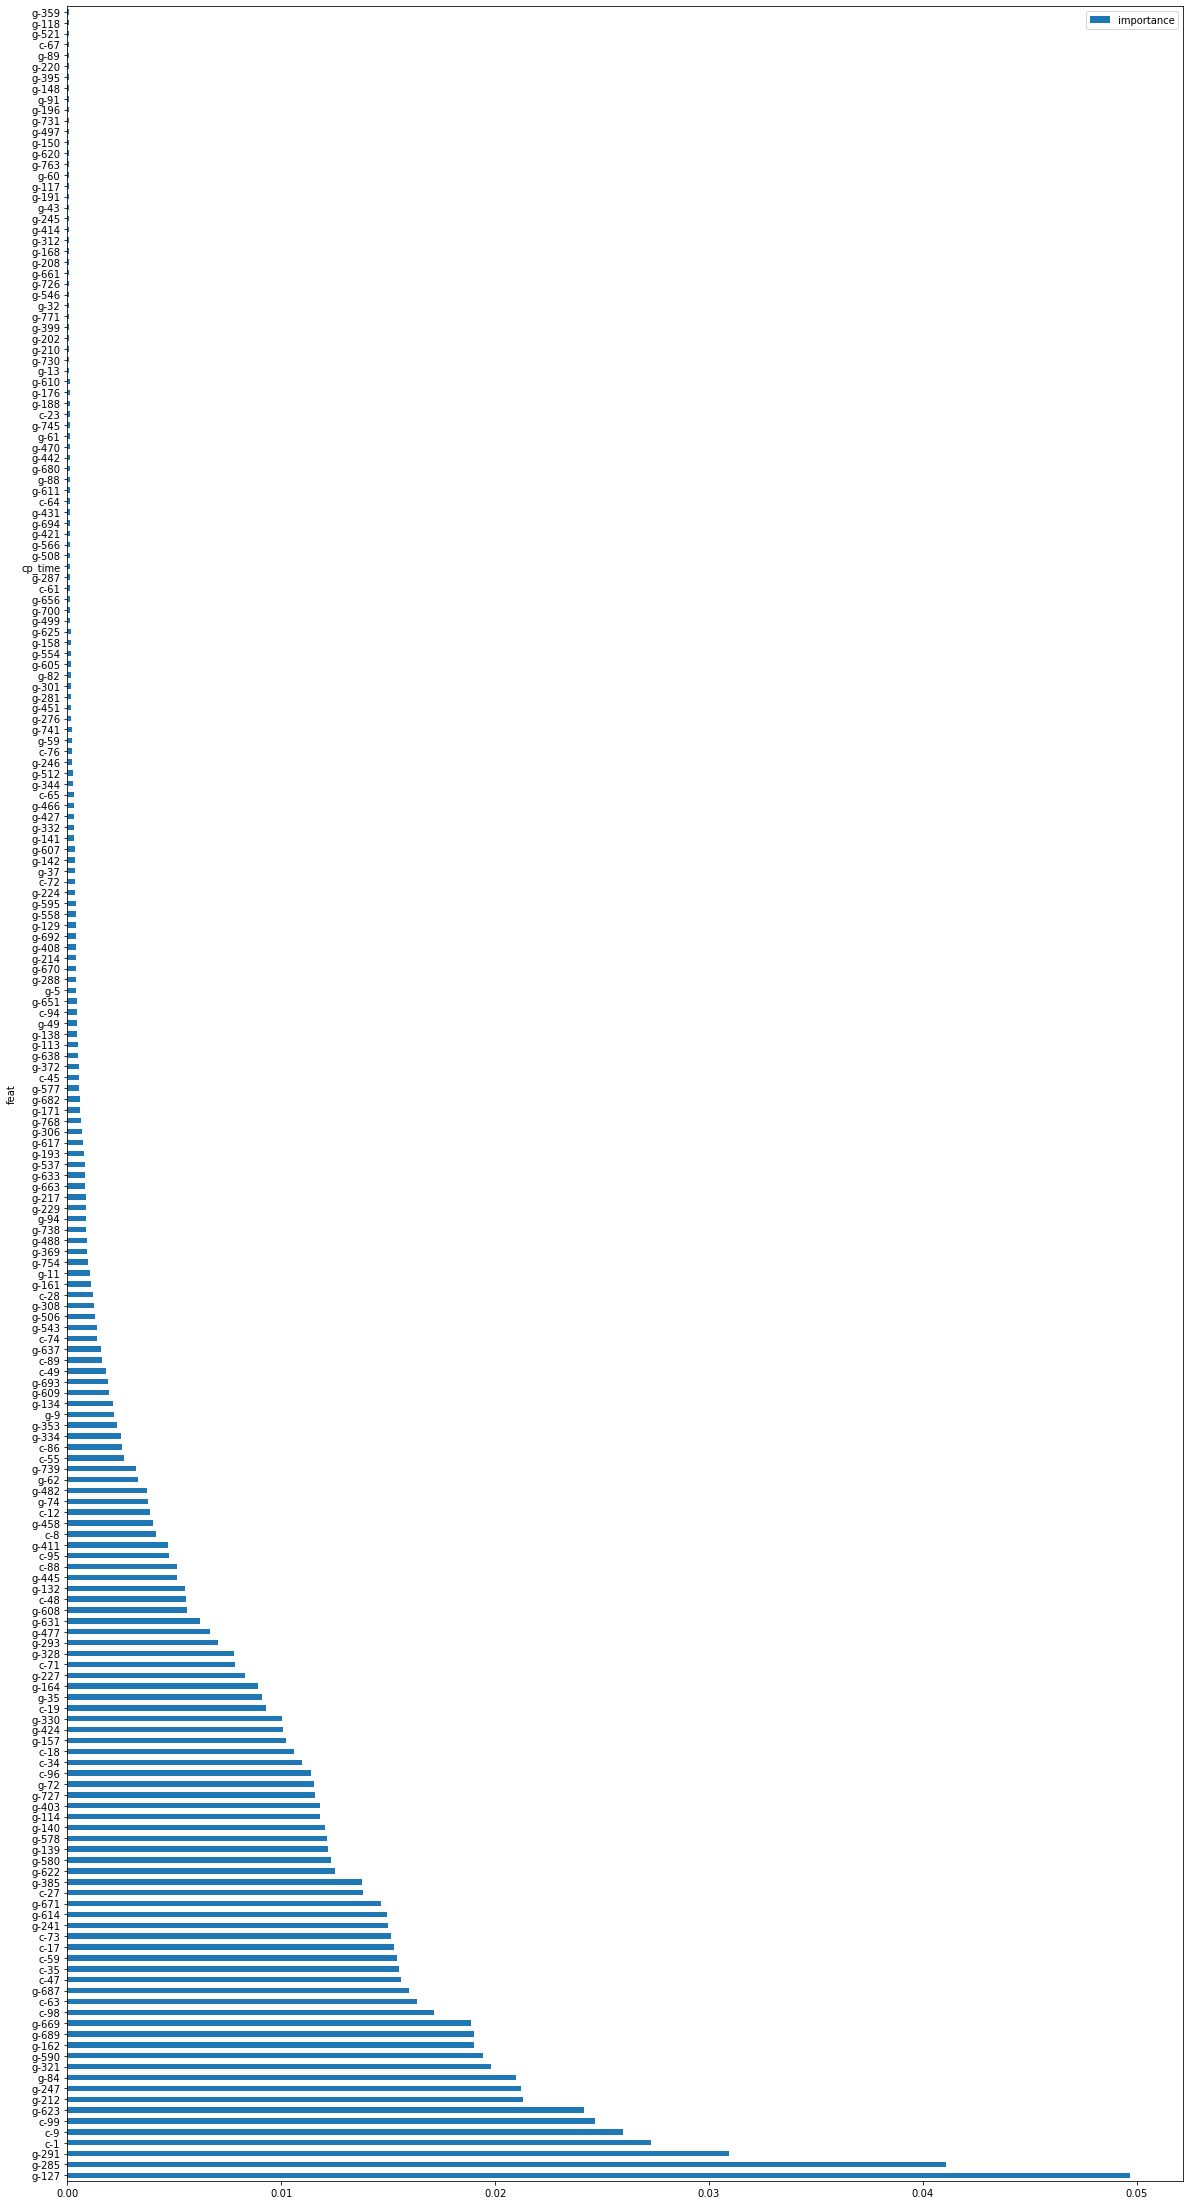

In [30]:
import matplotlib.pyplot as plt
test[:200].plot.barh(x="feat",y="importance",figsize=(20,40))
plt.show()

# Inference

In [24]:
if cfg.strategy == "KFOLD":
    oof_preds_all = []
    oof_targets_all = []
    scores_all =  []
    scores_auc_all= []
    preds_test = []
    for seed in range(cfg.num_ensembling):
        print("## SEED : ", seed)
        mskf = MultilabelStratifiedKFold(n_splits=cfg.SPLITS, random_state=cfg.seed+seed, shuffle=True)
        oof_preds = []
        oof_targets = []
        scores = []
        scores_auc = []
        p = []
        for j, (train_idx, val_idx) in enumerate(mskf.split(np.zeros(len(cat_tr)), targets_tr)):
            print("FOLDS : ", j)

            ## model
            X_train, y_train = torch.as_tensor(np.concatenate([cat_tr[train_idx], numerical_tr[train_idx] ], axis=1)), torch.as_tensor(targets_tr[train_idx])
            X_val, y_val = torch.as_tensor(np.concatenate([cat_tr[val_idx], numerical_tr[val_idx] ], axis=1)), torch.as_tensor(targets_tr[val_idx])
            model = TabNetRegressor(n_d=24, 
                                    n_a=24, 
                                    n_steps=1, 
                                    gamma=1.3, 
                                    lambda_sparse=0, 
                                    cat_dims=cfg.cat_dims, 
                                    cat_emb_dim=cfg.cat_emb_dim, 
                                    cat_idxs=cfg.cats_idx, 
                                    optimizer_fn=torch.optim.Adam,
                                    optimizer_params=dict(lr=2e-2), 
                                    mask_type='entmax', 
                                    device_name=cfg.device, 
                                    scheduler_params=dict(milestones=[ 50,100,150], gamma=0.9), 
                                    scheduler_fn=torch.optim.lr_scheduler.MultiStepLR)
            #'sparsemax'
            
            name = cfg.save_name + f"_fold{j}_{seed}"
            model.load_model(name)
            # preds on val
            preds = model.predict(X_val)
            preds = torch.sigmoid(torch.as_tensor(preds)).detach().cpu().numpy()
            score = log_loss_multi(y_val, preds)
            
            # preds on test
            temp = model.predict(X_test)
            p.append(torch.sigmoid(torch.as_tensor(temp)).detach().cpu().numpy())
            ## save oof to compute the CV later
            oof_preds.append(preds)
            oof_targets.append(y_val)
            scores.append(score)
            scores_auc.append(auc_multi(y_val,preds))
            print(f"validation fold {j} : {score}")
        p = np.stack(p)
        preds_test.append(p)
        oof_preds_all.append(np.concatenate(oof_preds))
        oof_targets_all.append(np.concatenate(oof_targets))
        scores_all.append(np.array(scores))
        scores_auc_all.append(np.array(scores_auc))
    preds_test = np.stack(preds_test)

## SEED :  0
FOLDS :  0
Device used : cuda


FileNotFoundError: [Errno 2] No such file or directory: '../data/tabnet-weights-public/tabnet-raw-public-step1/tabnet_raw_step1_fold0_0/model_params.json'